# Análisis De Clúster Automático


### Autor: 
    Marisol Correa Henao (mcorreah@unal.edu.co)
### Tutor:
    Juan David Velasquez Henao (jdvelasq@unal.edu.co)
                    
### Fecha creación:     
    28/03/2019

### Descripción:        
    Software para Análisis de cluster automático
    * Pasos Opcionales 

## Dependencias:       

A continuación se cargan las librerías necesarias

In [50]:
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from yellowbrick.cluster import KElbowVisualizer
import warnings
import ipywidgets as widgets
from IPython.display import display
from ipyfilechooser import FileChooser
import os
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import estimate_bandwidth
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
import ast

## Parametrización

Se crean los parámetros necesarios

## Funciones para clusterización

Se crean las funciones necesarias para cada etapa de la clusterización

In [2]:
##
# Leer archivo
##

def leer_datos(ruta, enc, sp):
    data = None
    start_time = time.time()
    
    # Obtenemos la extensión del archivo
    file_ext = ruta.split(".")[-1]
    #data = pd.read_sql(ruta + "." + archivo,cn)
    # Si file_ext es xlsx se leerá la base usando la función de pandas read_excel.
    if file_ext == 'xlsx':
        print("Leyendo el fichero " + ruta)
        
        # INTENTAMOS LEER EL FICHERO CON LA LIBRERÍA PANDAS DE PYTHON.
        try:
            data = pd.read_excel(ruta, na_values = 'None')            
        # Si falla la lectura del archivo finalizamos la ejecución y escribimos en el log
        except Exception as e:
            msg = "ERROR: " + str(e)

            # Finalizamos el programa y mostramos un mensaje de alerta.
            sys.exit("¡" + msg + "! \n\tLA EJECUCIÓN FINALIZÓ...")

    # Si file_ext es csv se leerá la base usando la función de pandas read_csv.
    elif file_ext == 'csv' or file_ext == 'txt':
        print("Leyendo el fichero " + ruta)

        # Intentamos leer el archivo con pandas
        try:
            data = pd.read_csv(ruta, sep = sp,  low_memory = False, na_values = 'None')            
        # Si falla la lectura del archivo finalizamos la ejecución y escribimos en el log.
        except Exception as e:
            msg = "ERROR: " + str(e)

            # Finalizamos el programa y mostramos un mensaje de alerta.
            sys.exit("¡" + msg + "! \n\tLA EJECUCIÓN FINALIZÓ...")
            
    # Si file_ext no esta contemplado se escribirá en el log el error correspondiente.
    else:
        msg = "ERROR: La extensión " + ruta.upper() + " no es válida para la lectura de datos."

        # Finalizamos el programa y mostramos un mensaje de alerta.
        sys.exit("¡" + msg + "! \n\tLA EJECUCIÓN FINALIZÓ...")
        
    tiempo_usado_lc = (time.time() - start_time)/60 
    tiempo_usado_lc = '{:6.2f}'.format(tiempo_usado_lc)
    print("\tArchivo leido satisfactoriamente en:" + str(tiempo_usado_lc) + " minutos")
    print("\tSe cargaron {:,} filas y {:,} columnas".format(data.shape[0], data.shape[1]))    
    
    # Regresamos el fichero leido como un data frame.
    return data, tiempo_usado_lc


##
# variables identificadoras, nulas y a omitir
##
def tipo_variables(datos,ncat):
    ids=[]
    omitir=[]
    for i in datos.columns:
        #ids sugeridos
        if(datos[i].nunique() == datos.shape[0]): ids.append(i)
        # Nulos
        if(all(datos[i].isnull())): omitir.append(i)
        # Si los datos que hay en la columna son siempre el mismo, se da una advertencia
        if(datos[i].nunique() == 1): omitir.append(i)        

    ##
    # Identificar tipo variables
    ##

    tipos={}
    for i in range(0,len(datos.dtypes.value_counts())):
        tipo_dato = datos.dtypes.value_counts().index[i].kind
        tipoj=[]
        for j in range(0,datos.shape[1]):
            if(datos.dtypes[j].kind==tipo_dato):
                tipoj.append(datos.dtypes.index[j])
        tipos[tipo_dato]=tipoj
    '''
    if not np.issubdtype(df_analysis[col].dtype, np.number):
                print(f'La variable {cb}{col}{cc} NO es numerica')
                continue
    '''
    numeric = tipos.get('i',[]) + tipos.get('f',[]) + tipos.get('u',[])
    c = datos[numeric].nunique()
    categoric2 = c[c<=ncat].axes[0].tolist()    
    for i in categoric2: numeric.remove(i)
    categoric =  categoric2 + tipos.get('b',[])+tipos.get('c',[])+tipos.get('m',[])+tipos.get('M',[])+tipos.get('O',[])+tipos.get('S',[])+tipos.get('U',[])+tipos.get('V',[])
    datos[categoric2] = datos[categoric2].astype('str')
    categoric = [x for x in categoric if(x not in omitir and x not in ids) ]   
    numeric = [x for x in numeric if(x not in omitir and x not in ids) ]
    return numeric, categoric, omitir, ids


#######
#  Esta función permite cambiar el tipo de datos
#  2: Si el cambio es a un tipo categórico
#  1: Si el cambio es a un tipo númerico
#  0: Si el cambio es a un tipo omitir
#  -1: Si el cambio es a un tipo identificador
#########
def cambiar_tipo_a(datos,variables,tipo,numeric,categoric,omitir,ids):
    data = datos.copy()
    for i in variables: 
        if(tipo==1): # cambiar a númerico
            if(i in categoric): categoric.remove(i)
            if(i in omitir): omitir.remove(i)
            if(i in ids): ids.remove(i)
            if(i not in numeric): numeric.append(i)
            data[i] = data[i].astype('float',errors="ignore")
        elif(tipo==2): # cambiar a categorico
            if(i in numeric): numeric.remove(i)
            if(i in omitir): omitir.remove(i)
            if(i in ids): ids.remove(i)
            if(i not in categoric): categoric.append(i)
            data[i] = data[i].astype('str',errors="ignore")
        elif(tipo==0): #cambiar a omitir
            if(i in categoric): categoric.remove(i)
            if(i in numeric): numeric.remove(i) 
            if(i in ids): ids.remove(i)
            if(i not in omitir): omitir.append(i)
            data = data.drop(i,axis=1)            
        else: #cambiar a ids
            if(i in categoric): categoric.remove(i)
            if(i in numeric): numeric.remove(i) 
            if(i in omitir): omitir.remove(i)
            if(i not in ids): ids.append(i)
            data = data.drop(i,axis=1)    
        
    return data, numeric, categoric, omitir, ids

##
# Descriptivo (según tipo)
##


def descriptivo_num(datos,col,flag_zeros,ruta):

    # Hallamos los porcentajes de zeros y nulos de la base, correspondiente al despoblamiento.
    perc_zeros =  round((datos[datos[col] == 0].shape[0])*100/datos.shape[0], 2)
    perc_nulls = round((datos[col].shape[0] - datos[col].dropna().shape[0])*100/datos.shape[0], 2)

    # Hallamos el número de valores que no son cero y que tampoco son nulos.
    n_rows_clean = datos[~datos[col].isnull() & (datos[col] != 0)].shape[0]

    if flag_zeros == 1 and datos[[col]].nunique().values[0] != 2: 
        datos = datos[datos[col] != 0]

    # Calculamos el percentil 95 para gráficar correctamente el boxplot, ya que los outliers arruinan la gráfica.
    q95 = datos.quantile(q = 0.95).values[0] if any(datos[col].notnull()) else float('inf')

    # Contamos el número de outliers existentes (valores por encima del 95% de los datos).
    n_outliers = datos[datos[col] > q95].size

    # Creamos un data frame para almacenar las estadísticas
    df_other = pd.DataFrame(["{:0.2f}%".format(perc_zeros),"{:0.2f}%".format(perc_nulls), "{:,}".format(n_rows_clean), "{:,}".format(n_outliers)], 
                            index = ['ceros%', 'nulos%','total', 'outliers'],
                            columns=[col])

    # Calculamos las estadísticas de la columna analizada
    df_stats = np.round(datos[col].describe(percentiles = quantiles, include='all'),2).map("{:,}".format)
    # Eliminamos la columna count que se encuentra repetida
    df_stats = df_stats.drop(["count"])

    # Concatenamos los dos DataFrame de estadísticas
    df_stats = df_other.append(pd.DataFrame(df_stats))
    
    
    # Removemos los datos que se encuentren por encima del 99% de los datos para una mejor visualización de las gráficas.
    q99 = datos.quantile(q = 0.99).values[0] if any(datos[col].notnull()) else float('inf')
    datos = datos[datos[col] <= q99]

    # Creamos la figura y los axes donde se graficará.
    fig, axs = plt.subplots(1,2, figsize = (25, 9.6)) 

    # Agregamos titulo a la figura.
    fig.suptitle(col.upper().replace("_", " "), fontsize = 20)


    # Graficamos la función de densidad de probabilidad.
    plt.axes(axs[0])
    sns.set(style = "whitegrid")
    sns.kdeplot(datos[col], shade=True, color="r", legend=False)
    plt.ylabel("Density", fontsize = 16)
    plt.xlabel(col.replace("_", " "), fontsize = 16)

    # Graficamos el boxplot.
    plt.axes(axs[1])
    plt.grid(False)
    plt.boxplot(datos[col], widths = 0.09)
    plt.ylabel(col)

    # Convertimos las estadísticas en string con separación de miles para mejor visualización en la gráfica.
    df_stats_plot = df_stats[col]

    the_table = table(axs[1], df_stats_plot, loc='upper right', colWidths=[0.15, 0.3, 0.1], cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    plt.ylabel(col.replace("_", " "), fontsize = 16)
    try:
        os.stat(ruta + "\\Graficos")
    except:
        os.mkdir(ruta + "\\Graficos")
    # Guardamos la figura.
    plt.savefig( ruta + "\\Graficos\\" + col + ".png")
    
    return df_stats



def descriptivo_cat(datos,col,flag_zeros,ruta):
    # Hallamos los porcentajes de zeros y nulos de la base, correspondiente al despoblamiento.
    perc_zeros =  round((datos[datos[col] == "0"].shape[0])*100/datos.shape[0], 2)
    perc_nulls = round((datos[col].shape[0] - datos[col].dropna().shape[0])*100/datos.shape[0], 2)

    # Hallamos el número de valores que no son cero y que tampoco son nulos.
    n_rows_clean = datos[~datos[col].isnull() & (datos[col] != "0")].shape[0]

    if flag_zeros == 1 and datos[[col]].nunique().values[0] != 2: 
        datos = datos[datos[col] != "0"]
    
    categorias = 100 * dat[col].value_counts() / len(dat[col])
    unicos = dat[col].nunique()
    
    # Convertimos las estadísticas en string con separación de miles para mejor visualización en la gráfica.
    df_stats_plot = pd.DataFrame(["{:0.2f}%".format(perc_zeros),"{:0.2f}%".format(perc_nulls), "{:,}".format(n_rows_clean),"{:,}".format(unicos)], 
                            index = ['ceros%', 'nulos%','total', 'categorias'], 
                            columns = [col])
      # Creamos la figura y los axes donde se graficará.
    fig, axs = plt.subplots(1,3, figsize = (25, 9.6)) 

    # Agregamos titulo a la figura.
    fig.suptitle(col.upper().replace("_", " "), fontsize = 20)
 
    the_table = table(axs[1], df_stats_plot, loc='center', colWidths=[0.15, 0.3, 0.1], cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    plt.ylabel(col.replace("_", " "), fontsize = 16)
    axs[0].axis("off") 
    df_stats_plot = categorias.map(lambda x: "{:0.2f}%".format(x))

    the_table = table(axs[0], df_stats_plot, loc='upper right', colWidths=[0.15, 0.3, 0.1], cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    plt.ylabel(col.replace("_", " "), fontsize = 16)
    axs[1].axis("off") 

    #graficos categoricos
    plt.axes(axs[2])
    ax = sns.countplot(y=col, data=datos,order = datos[col].value_counts().index)
    plt.title(col)
    plt.xlabel('%')
    total = len(datos[col])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    try:
        os.stat(ruta + "\\Graficos")
    except:
        os.mkdir(ruta + "\\Graficos")
    plt.savefig( ruta + "\\Graficos\\" + col + ".png")
    
    # Cerramos la figura para que no se muestre en el notebook
#    plt.close()

    return categorias
      


def descriptivo_inicial(datos,numeric,categoric,ruta):

    # general
    datos.head(3)
    datos.info()
    datos.describe()
    if len(numeric)>0:
        dat[numeric].skew()
        dat[numeric].kurt()
        correlaciones = dat[numeric].corr()
        fig_size = (25,15)
        fig, ax = plt.subplots(figsize = fig_size)
        sns.heatmap(correlaciones, annot=True, fmt='.4f', 
                cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
        try:
            os.stat(ruta + "\\Graficos")
        except:
            os.mkdir(ruta + "\\Graficos")
        fig.savefig(ruta + "\\Graficos\\" + "correlaciones.png", bbox_inches = "tight")
    #    plt.close()
        for i in numeric:
            descriptivo_num(datos,i,zeros,ruta)
    for i in categoric:
        descriptivo_cat(datos,i,zeros,ruta)                                            
        
##
# datos atípicos y faltantes
##
def manejo_datos(datos,tipo,accion,col,valor):
    #accion:0 remover
    #acción:-1 imputar valor
    #acción:1 media
    #acción:2 mediana
    #acción:3 moda
    #tipo:0 atípico
    #tipo:1 nulo
    data = datos.copy()
    for i in col:        
        q99 = datos.quantile(q = 0.99).values[0] if any(datos[i].notnull()) else float('inf')
        if(accion!=0): #cambiar valor
            if(accion==1 and np.issubdtype(data[i].dtype, np.number)): # mean o moda
                valor = datos[i].mean()
            elif(accion==2 and np.issubdtype(data[i].dtype, np.number)): # mediana
                valor = datos[i].median()
            elif(accion!=-1): #moda o categórico media o mediana
                valor = datos[i].mode()            
            if(tipo==0): #atipico
                data.loc[data[i] > q99, i] = valor
            else: #nulos
                data[i] = data[i].fillna(valor)
        else: #remover
            if(tipo==0): #atipicos
                data = data[data[i] > q99]
            else: #nulos
                data = data[data[i].notna()]              
    return data


##
# Decodificar
##

def decodificar(numeric,categoric,metodnum,metodcat):
    if(len(numeric)>0):
        if(metodnum==1): #min max
            scaler = MinMaxScaler()
        else: #estandarizar
            scaler= StandardScaler()
        scaled_dat = scaler.fit_transform(numeric)
        scaled_dat = pd.DataFrame(scaled_dat, columns=numeric.columns)
    else:
        scaled_dat = pd.DataFrame([])
    if(len(categoric)>0):
        if(metodcat==1): #get dummies
            decoder_dat = pd.get_dummies(categoric)
        else: #decodificar, caso de los ordinales
            encoder = LabelEncoder ()
            decoder_dat = encoder.fit_transform(categoric)
    else:
        decoder_dat = pd.DataFrame([])
    data = pd.concat([scaled_dat, decoder_dat], axis=1)
    
    return data
        
        
    

##
# nro cluster
##
def get_elbow(datos,min,max,metodo):
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    if(metodo==1):
        metric = 'calinski_harabasz'
    elif(metodo==0):
        metric = 'silhouette'
    else:
        metric = 'distortion'
    visualizer = KElbowVisualizer(KMeans(), k=(min,max),metric=metric)
    warnings.filterwarnings('error')
    try:
        os.stat(ruta + "\\Graficos")
    except:
        os.mkdir(ruta + "\\Graficos")
    try:
        visualizer.fit(datos)
        visualizer.show( ruta + "\\Graficos\\codo.png")
    except Warning:
        print('el rango no permite hallar un número óptimo de cluster')        
        return 3
    return visualizer.elbow_value_
       
##
# cluster
##
def cluster(datos,metodo,parametros):
    if(metodo=="Spectral"):
        model = SpectralClustering()
    elif(metodo=="Agglomerative"):
        model = AgglomerativeClustering()
    elif(metodo=="DBSCAN"):
        model = DBSCAN()
    elif(metodo=="Optics"):
        model = OPTICS()
    else:
        model = KMeans()
    model.set_params(**parametros)
    model.fit_predict(datos)
    return model.labels_


##
# interpretación
##
def interpretacion(datos,numeric,categoric):   
     
#porcentaje en cada cluster
    ax = sns.countplot(y='cluster', data=datos)
    plt.title('Porcentaje Cluster')
    plt.xlabel('%')
    total = len(datos['cluster'])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    try:
        os.stat(ruta + "\\Resultados")
    except:
        os.mkdir(ruta + "\\Resultados")
    plt.savefig( ruta + "\\Resultados\\general.png")

#boxplots

            # Gráficamos un boxplot por cada clúster
    for col in numeric:
        fig, axs = plt.subplots(1,2, figsize = (25,9.6)) 

    # Agregamos titulo a la figura.
        fig.suptitle(col.upper().replace("_", " "), fontsize = 20)
        grouped_data = datos[[col,'cluster']].groupby('cluster')
        # Estadísticas para todas las columnas numéricas por cluster
        tab = np.round(grouped_data.describe(),2)
        
        the_table = table(axs[1], tab, loc='center',cellLoc = 'center')
        the_table.set_fontsize(14)
        the_table.scale(1.3, 2)
        axs[1].axis("off")  
        
        plt.axes(axs[0])
        ax = sns.boxplot(y = col, x = 'cluster', data = datos, orient = "v", width = 0.45, palette = "Set1")
        
                    # Pesonalizamos la gráfica
        ax.set_ylabel(col.replace("_", " "), fontsize = 15)
        ax.set_xlabel("Número clúster", fontsize = 15)
        try:
            os.stat(ruta + "\\Resultados")
        except:
            os.mkdir(ruta + "\\Resultados")
        plt.savefig( ruta + "\\Resultados\\" + col + ".png")
        

   # Gráfico de barras de sobreviviviente segun clase
    for col in categoric:
        fig, axs = plt.subplots(1,1, figsize = (25,9.6)) 

    # Agregamos titulo a la figura.
        fig.suptitle(col.upper().replace("_", " "), fontsize = 20)
        tab = np.round(pd.crosstab(index=datos[col],
            columns=datos['cluster']).apply(lambda r: r/r.sum() *100,axis=0),2)
        the_table = table(axs, tab, loc='center',cellLoc = 'center')
        axs.axis("off")    
        try:
            os.stat(ruta + "\\Resultados")
        except:
            os.mkdir(ruta + "\\Resultados")
        plt.savefig( ruta + "\\Resultados\\" + col + "2.png")     
       # plt.axes(axs)
        tab.plot(kind='bar')       
        plt.savefig( ruta + "\\Resultados\\" + col + ".png")                    

       
def principales_vars(datos_norm):
    perfilado = datos_norm.groupby('cluster').mean() 
    perfilado.reset_index( drop = False, inplace = True )
    perfilado['__fac_x__'] = perfilado['cluster'].map(lambda x: f'Cluster {x+1}')                                       
    perfilado.drop('cluster', axis = 1, inplace = True )    

    fac_y = list(perfilado.drop( ['__fac_x__'], axis = 1 ).columns)
    fac_x = list(perfilado['__fac_x__'])      

    list_of_lists = [ [name] * len(perfilado['__fac_x__'].unique()) for name in fac_y ]
    y = [ itm for list_ in list_of_lists for itm in list_ ]
    x = fac_x * len(fac_y)
    
    tup_key = list( zip(y, x) )
    medias_clus = [ perfilado.loc[ perfilado["__fac_x__"] == tup[1], tup[0] ].values[0]  for tup in tup_key ]                  
    data = dict(x = x, y = y, medias_clus = medias_clus)
    
    main_vars = pd.DataFrame(data)

    main_vars = main_vars.sort_values(['x', 'medias_clus'], ascending = [1,0]).groupby('x').apply(lambda x: x)
    
    top_vars = main_vars.groupby('x').head(5).reset_index(drop = True)
    bottom_vars = main_vars.groupby('x').tail(5).reset_index(drop = True)
    main_vars = pd.concat([top_vars, bottom_vars])
    main_vars = main_vars.sort_values(['x', 'medias_clus'], ascending = [1,0])

    return main_vars
##
# exportar
##

def exportar(datos,ruta_salida,nombre_archivo,formato):
    if(formato==1):
        datos.to_excel(ruta_salida.replace("\\", '/') + '/' + nombre_archivo+".xlsx")
    else:
        datos.to_csv(ruta_salida.replace("\\", '/') + '/' + nombre_archivo+".csv")
        
def on_button_clicked(a):
    print("CAMBIOS:")
    global numn,catn,idsn,omitn
    numn=[]
    catn=[]
    idsn=[]
    omitn=[]
    for i in num2:
        if(i.value!='Numerica'):
            if i.value == 'Categorica':
                catn.append(i.description)
            elif i.value == 'Identificador':
                idsn.append(i.description)
            else:
                omitn.append(i.description)
            print('cambió ' + str(i.description) + " de Númerica a: " + str(i.value))
    for i in cat2:
        if(i.value!='Categorica'):
            if i.value == 'Numerica':
                numn.append(i.description)
            elif i.value == 'Identificador':
                idsn.append(i.description)
            else:
                omitn.append(i.description)
            print('cambió ' + str(i.description) + " de Categorica a: " + str(i.value))
    for i in ids2:
        if(i.value!='Identificador'):
            if i.value == 'Numerica':
                numn.append(i.description)
            elif i.value == 'Categorica':
                catn.append(i.description)
            else:
                omitn.append(i.description)
            print('cambió ' + str(i.description) + " de Identificador a: " + str(i.value))
    for i in omit2:
        if(i.value!='Omitir'):
            if i.value == 'Numerica':
                numn.append(i.description)
            elif i.value == 'Categorica':
                catn.append(i.description)
            else:
                idsn.append(i.description)
            print('cambió ' + str(i.description) + " de Omitir a: " + str(i.value))
            
def on_button_clicked2(a):
    for i in cambios_deco:
        if(i.value!=i.description):
            cat_uno.loc[cat_uno[i.placeholder]==i.description,i.placeholder] = i.value

##
# selección de parametros clusterización
##
def bestparam(datos,parametros,modelo,score):
    best_score=-1
    best_grid=-1
    parameter_grid = ParameterGrid(parametros)
    for g in parameter_grid:
        modelo.set_params(**g)
        modelo.fit(datos)
        if(len(set(modelo.labels_))>1):
            if(score==1):
                ss = metrics.calinski_harabasz_score(datos, modelo.labels_)
                if best_score==-1 or ss > best_score:
                    best_score = ss
                    best_grid = g
            elif(score==2):
                ss = metrics.davies_bouldin_score(datos, modelo.labels_)
                if best_score==-1 or ss < best_score:
                    best_score = ss
                    best_grid = g
            else: #silhouette_score
                ss = metrics.silhouette_score(datos, modelo.labels_)
                if best_score==-1 or ss > best_score:
                    best_score = ss
                    best_grid = g
            print('Parametro: ', g, 'Score: ', ss)

    return [best_score,best_grid]


def select_model(datos,mini,maxi,metrica):
    modelo_kmeans = bestparam(datos, {'n_clusters': list(range(mini,maxi+1))}, KMeans(),metrica)
    modelo_kmeans.append("KMeans")
    modelo_spectral = bestparam(datos, {'n_clusters': list(range(mini,maxi+1)),'affinity':['rbf', 'nearest_neighbors']}, SpectralClustering(),metrica)
    modelo_spectral.append("Spectral")
    modelo_dbscan = bestparam(datos, {'eps': [0.9, 1.0, 5.0, 10.0, 12.0, 14.0, 20.0],'min_samples': [2, 5, 7, 10]}, DBSCAN(),metrica)
    modelo_dbscan.append("DBSCAN")
    modelo_agglo = bestparam(datos, {'n_clusters': list(range(mini,maxi+1)),'linkage':['ward', 'complete','average', 'single']}, AgglomerativeClustering(),metrica)
    modelo_agglo.append("Agglomerative")
    modelo_optics = bestparam(datos, {'eps': [0.9, 1.0, 5.0, 10.0, 12.0, 14.0, 20.0],'min_samples': [2, 5, 7, 10]}, OPTICS(),metrica)
    modelo_optics.append("Optics")
    modelos=pd.DataFrame([modelo_kmeans,modelo_spectral,modelo_dbscan,modelo_agglo,modelo_optics])
    modelos=modelos.drop(modelos[modelos[0]==-1].index)
    if(metrica==2):
        modelos=modelos.sort_values(0,ascending=True).iloc[0,:]
    else:
        modelos=modelos.sort_values(0,ascending=False).iloc[0,:]
    return modelos

##
# Metricas Modelo
##
    
def metricas_supervisado(real,predict):
    print('homo\tcompl\tv-meas\tARI\tAMI')
    print(50 * '-')

    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          %(homogeneity_score(real, predict),
            completeness_score(real, predict),
            v_measure_score(real, predict),
            adjusted_rand_score(real, predict),
            adjusted_mutual_info_score(real,  predict)))

def metricas_no_supervisado(data,predict):
    print('silhouette\tcalinski_harabasz\tdavies_bouldin')
    print(60 * '-')

    print('%.3f\t\t%.3f\t\t\t%.3f'
          %(silhouette_score(data, predict),
    calinski_harabasz_score(data, predict),
    davies_bouldin_score(data, predict)))

In [3]:
catn=[]
numn=[]
omitn=[]
idsn=[]
num2 = []
cat2 = []
ids2 = []
omit2 = []
# Si flag_zeros = 1 se realiza un análisis excluyendo los ceros.
zeros = 0
ncat = 10
quantiles = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
variables = []
tipo_cambio = 0
min = 2
max = 6

## Lectura de datos

In [4]:
fc = FileChooser('/')
display(fc)
sep=widgets.RadioButtons( options=[';', ',', ('tab','\t')], description ='Separador',disabled=False)
enco=widgets.RadioButtons( options=['ISO-8859-1', 'ascii', 'latin_1','utf_8'], description ='Encoding',disabled=False)
opciones=widgets.HBox([sep,enco])
display(opciones)

FileChooser(path='C:\', filename='', title='', show_hidden=False, select_desc='Select', change_desc='Change', …

In [5]:
ruta = fc.selected_path
archivo = fc.selected_filename

In [6]:
dat,tiempo = leer_datos(ruta + '\\' + archivo,enco.value,sep.value)
base = dat.copy()
base_dep1 = dat.copy()
base_dec = dat.copy()

Leyendo el fichero C:\Users\Famil\Documents\aniosconstvsvinc.xlsx
	Archivo leido satisfactoriamente en:  0.01 minutos
	Se cargaron 49 filas y 5 columnas


In [7]:
dat

,segm,tipo_cli,anios_const,anios_vinc,count
0,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 5,92
1,NEGOCIOS & INDEPEND,PERSONA JURíDICA,mas de 10,menos de 10,103240
2,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 10,118
3,PYMES,PERSONA NATURAL,menos de 2,menos de 5,2
4,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 10,menos de 5,112
5,GOBIERNO DE RED,PERSONA JURíDICA,mas de 10,menos de 10,739
6,PYMES,PERSONA NATURAL,menos de 2,menos de 10,3
7,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,mas de 10,92
8,NEGOCIOS & INDEPEND,PERSONA NATURAL,mas de 10,mas de 10,484068
9,EMPRESARIAL,PERSONA NATURAL,mas de 10,mas de 10,284


## Tipo de Variables *

In [8]:
num,cat,omit,ids = tipo_variables(dat,ncat)

In [9]:
for i in num:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Numerica',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    num2.append(aux)
    
for i in cat:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Categorica',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    cat2.append(aux)
    
for i in ids:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Identificador',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    ids2.append(aux)
    
for i in omit:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Omitir',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    omit2.append(aux)
select_button = widgets.Button(
    description='OK', # User defined
    disabled=False
)
display(select_button)
select_button.on_click(on_button_clicked)

ToggleButtons(description='count', options=('Numerica', 'Categorica', 'Identificador', 'Omitir'), value='Numer…

ToggleButtons(description='segm', index=1, options=('Numerica', 'Categorica', 'Identificador', 'Omitir'), valu…

ToggleButtons(description='tipo_cli', index=1, options=('Numerica', 'Categorica', 'Identificador', 'Omitir'), …

ToggleButtons(description='anios_const', index=1, options=('Numerica', 'Categorica', 'Identificador', 'Omitir'…

ToggleButtons(description='anios_vinc', index=1, options=('Numerica', 'Categorica', 'Identificador', 'Omitir')…

Button(description='OK', style=ButtonStyle())

CAMBIOS:


In [10]:
base,num, cat, omit, ids = cambiar_tipo_a(dat,numn,1,num,cat,omit,ids)
base,num, cat, omit, ids = cambiar_tipo_a(base,catn,2,num,cat,omit,ids)
base,num, cat, omit, ids = cambiar_tipo_a(base,idsn,-1,num,cat,omit,ids)
base,num, cat, omit, ids = cambiar_tipo_a(base,omitn,0,num,cat,omit,ids)
numn=[]
catn=[]
omitn=[]
idsn=[]

## Análisis Descriptivo *

En la carpeta ./Graficos encontrarás las gráficas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   segm         49 non-null     object
 1   tipo_cli     49 non-null     object
 2   anios_const  49 non-null     object
 3   anios_vinc   49 non-null     object
 4   count        49 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ KB


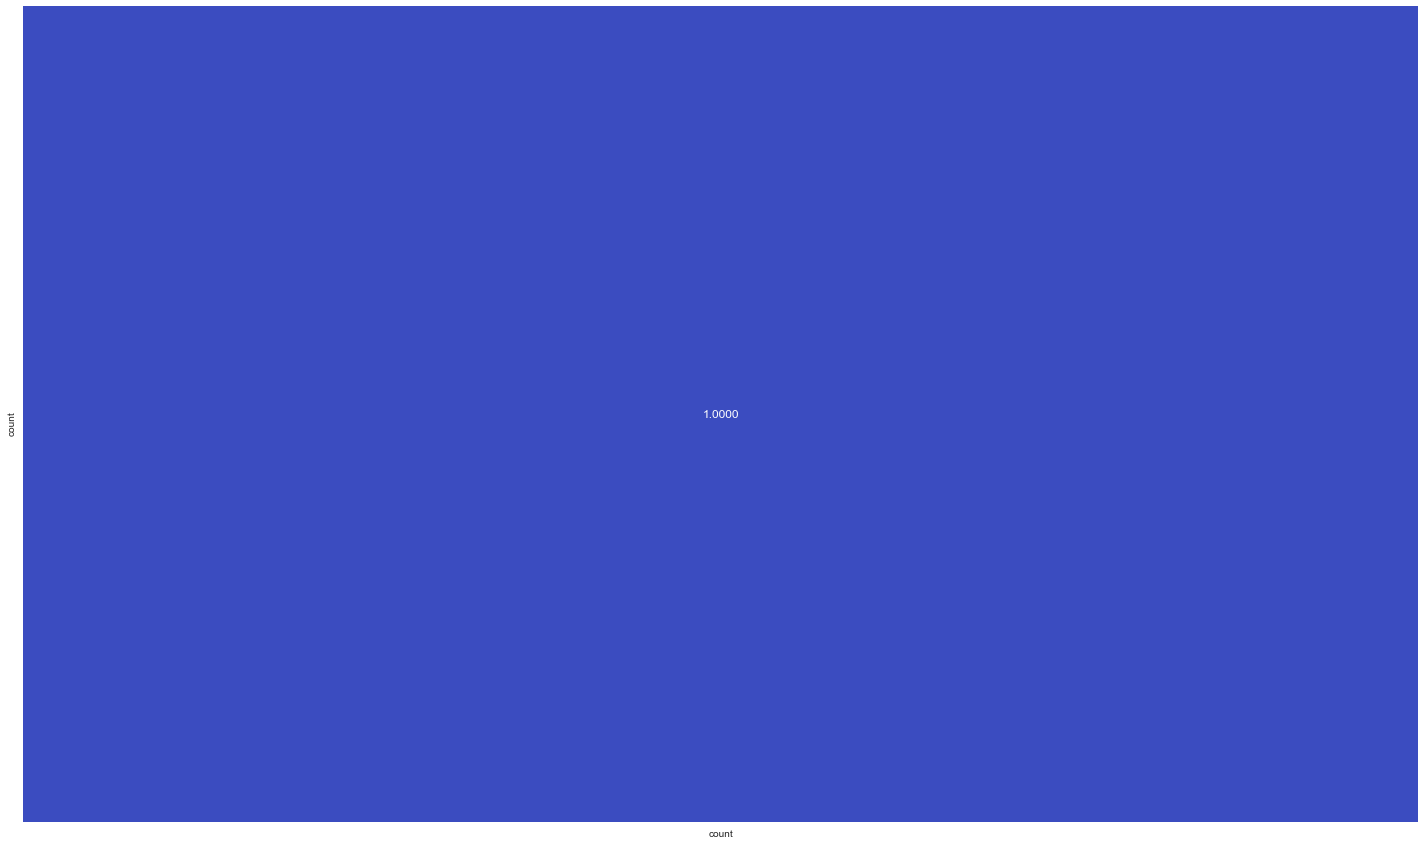

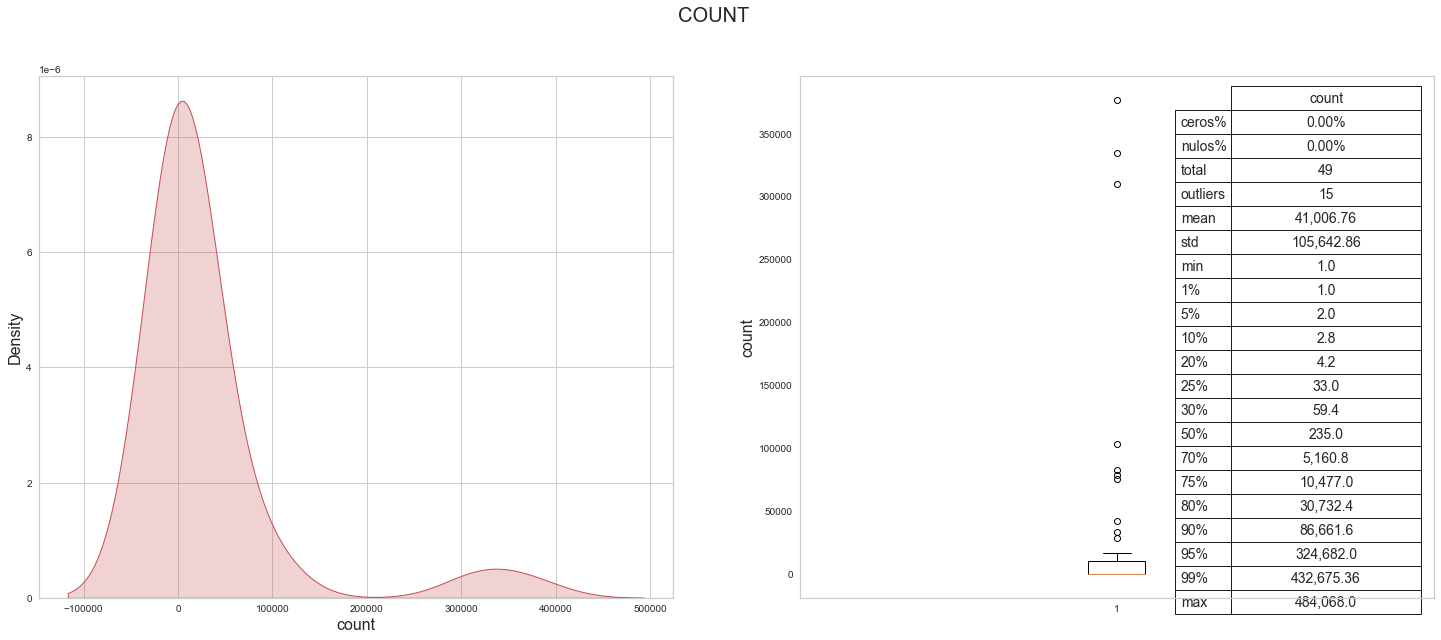

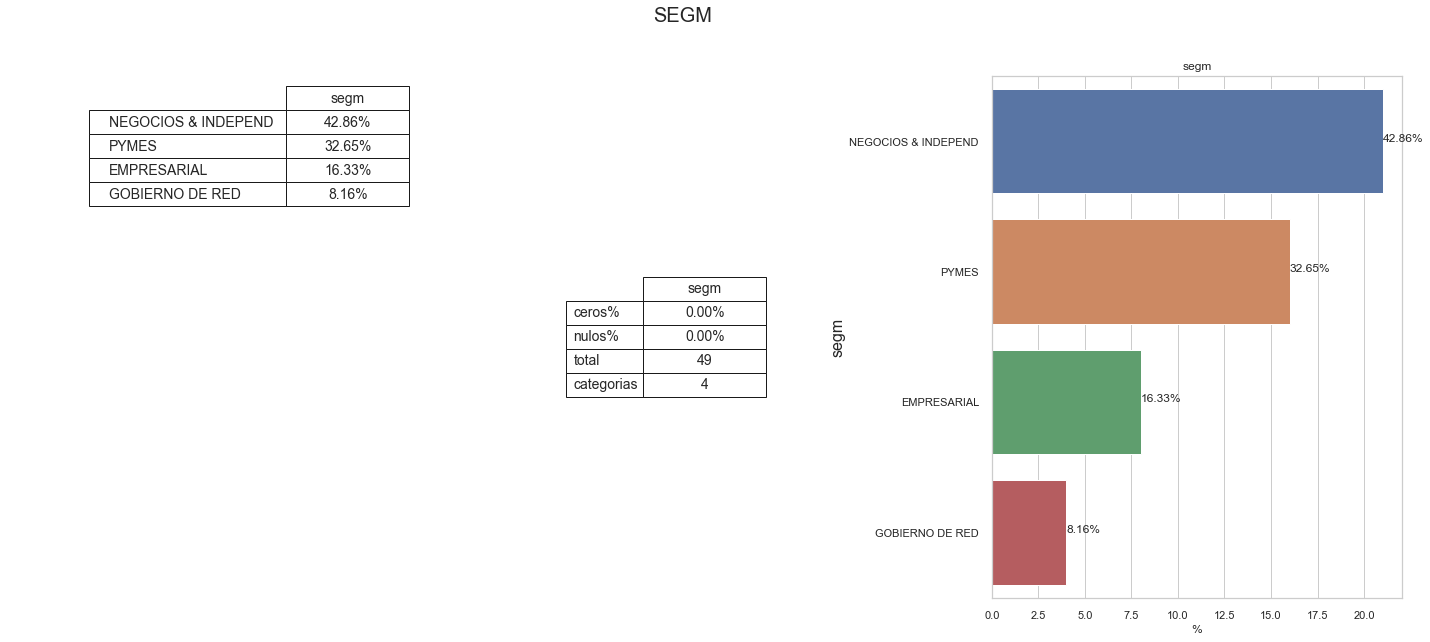

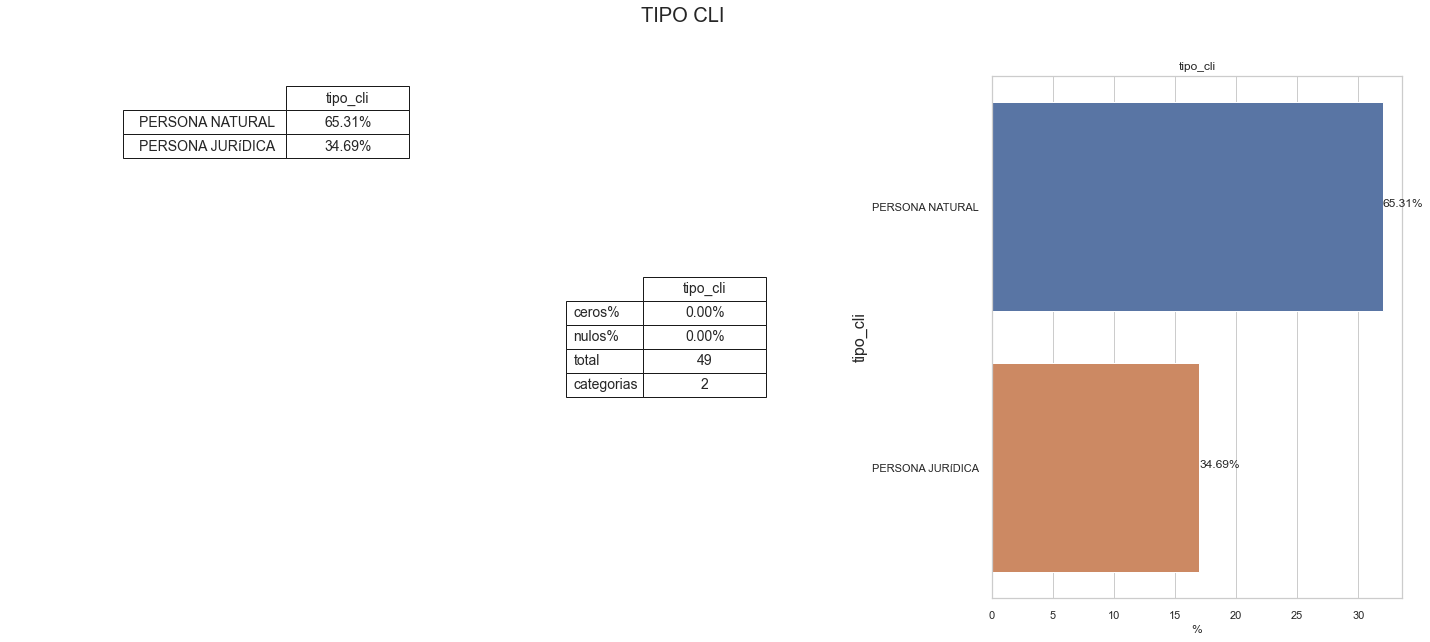

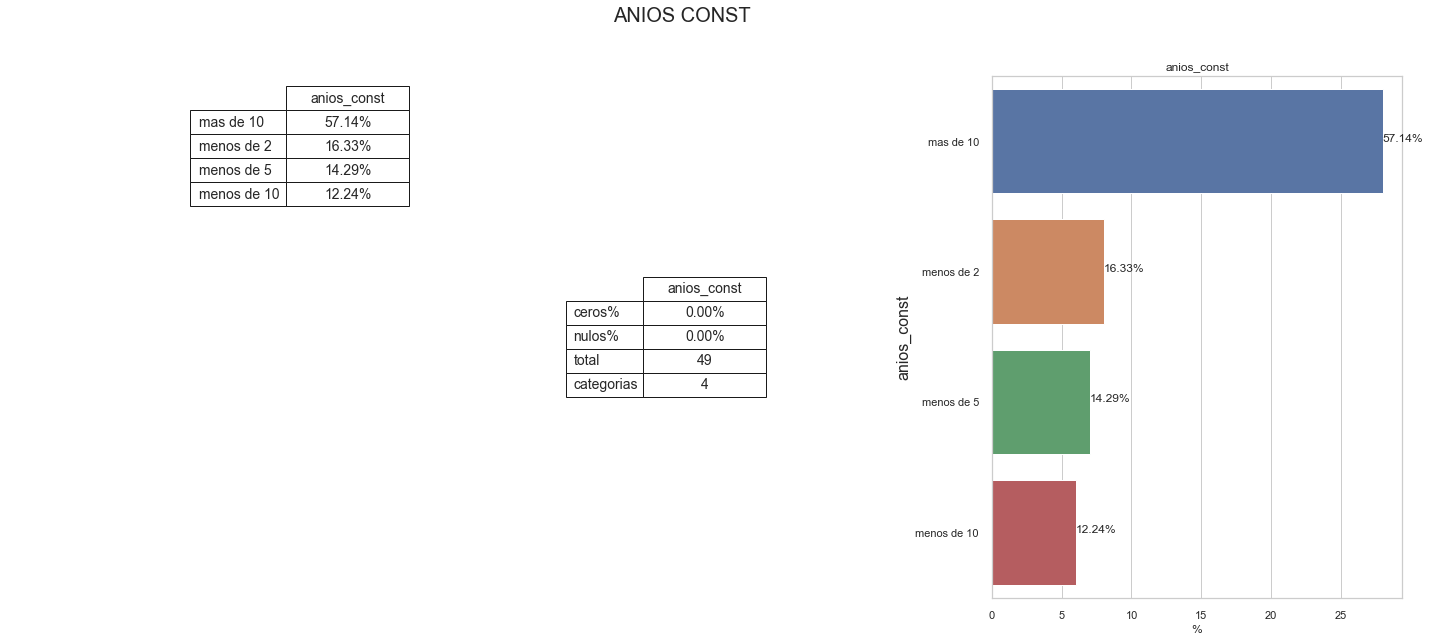

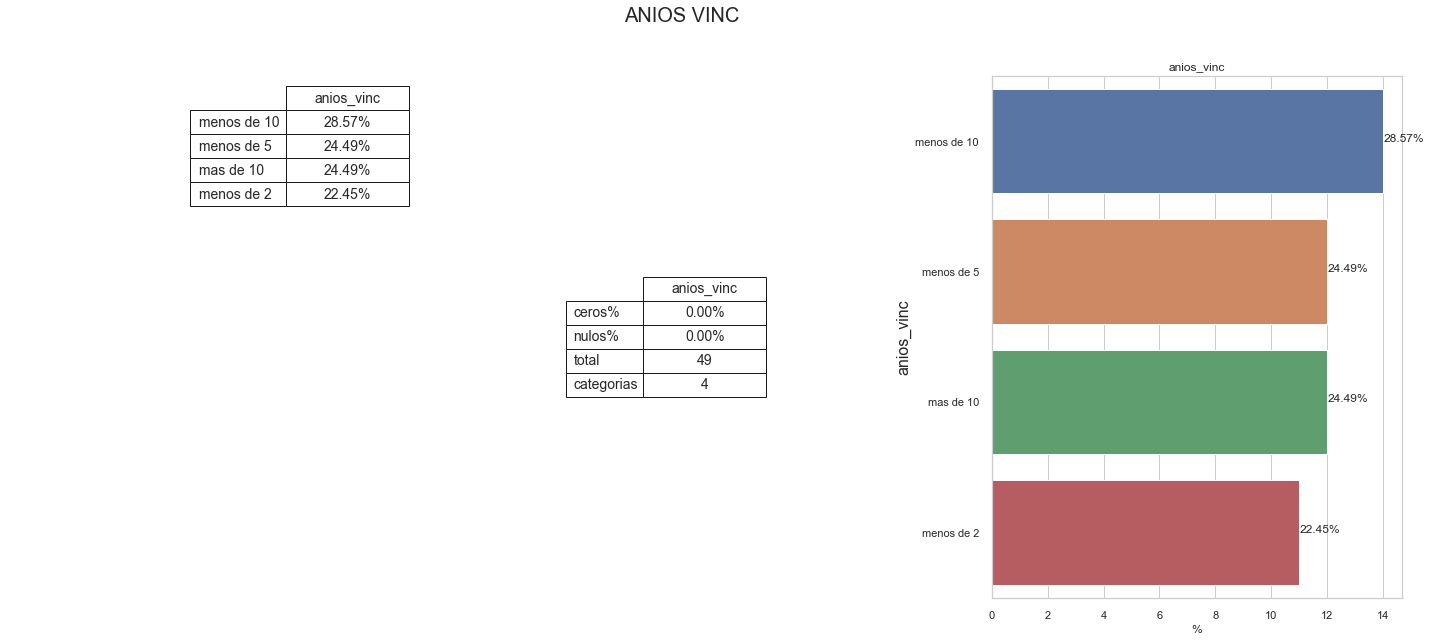

In [11]:
descriptivo_inicial(base,num,cat,ruta)

## Imputar Variables *

### Datos Atípicos

In [12]:
accion_atip = widgets.RadioButtons(
    options=[('Imputar',-1), ('Reemplazar con Media',1), ('Reemplazar con Mediana',2),('Reemplazar con Moda',3),('Remover',0)],
     value=-1,
    description='¿Qué desea hacer con los datos atípicos?:',
    disabled=False
)
atip = widgets.Text(
    value='0',
    placeholder='Valor para reemplazar datos atípicos',
    description='Por Valor:',
    disabled=False
)
opc_atip=widgets.HBox([accion_atip,atip])
display(opc_atip)

In [13]:
#accion:0 remover
#acción:-1 imputar valor
#acción:1 media
#acción:2 mediana
#acción:3 moda
#tipo:0 atípico
#tipo:1 nulo
#if(accion_atip.label == 'Remover'):
#    base_dep0 = manejo_datos(base,0,0,num,0) #remover atipicos
#elif(accion_atip.label == 'Reemplazar con Media'):
#    base_dep0 = manejo_datos(base,0,1,num,0) #atipicos cambiar a la media
#elif(accion_atip.label == 'Reemplazar con Mediana'):
#    base_dep0 = manejo_datos(base,0,2,num,0) #atipicos cambiar a mediana
#elif(accion_atip.label == 'Reemplazar con Moda'):
#    base_dep0 = manejo_datos(base,0,3,num,0) #atipicos cambiar a moda
#else:
#    base_dep0 = manejo_datos(base,0,-1,num,int(atip.value)) #atipicos cambiar a valor

base_dep0 = manejo_datos(base,0,accion_atip.value,num,int(atip.value)) 

### Datos Nulos

In [14]:
accion_nul = widgets.RadioButtons(
    options=['Imputar', 'Reemplazar con Media', 'Reemplazar con Mediana','Reemplazar con Moda','Remover'],
     value='Imputar',
    description='¿Qué desea hacer con los datos nulos?:',
    disabled=False
)
nul = widgets.Text(
    value='0',
    placeholder='Valor para reemplazar datos nulos',
    description='Por Valor:',
    disabled=False
)
opc_nul=widgets.HBox([accion_nul,nul])
display(opc_nul)

In [15]:
#accion:0 remover
#acción:-1 imputar valor
#acción:1 media
#acción:2 mediana
#acción:3 moda
#tipo:0 atípico
#tipo:1 nulo
if(accion_nul.label == 'Remover'):
    base_dep1 = manejo_datos(base_dep0,1,0,num,0) #remover nulos
elif(accion_nul.label == 'Reemplazar con Media'):
    base_dep1 = manejo_datos(base_dep0,1,1,num,0) #nulos cambiar a la media
elif(accion_nul.label == 'Reemplazar con Mediana'):
    base_dep1 = manejo_datos(base_dep0,1,2,num,0) #nulos cambiar a mediana
elif(accion_nul.label == 'Reemplazar con Moda'):
    base_dep1 = manejo_datos(base_dep0,1,3,num,0) #nulos cambiar a moda
else:
    base_dep1 = manejo_datos(base_dep0,1,-1,num,int(nul.value)) #nulos cambiar a valor

## Preparación de variables *

### Variables a conservar sin decodificar

In [16]:
col_conserv=[]
for i in base_dep1.columns:
    col_conserv.append(widgets.Checkbox(
    value=False,
    description=i,
    disabled = False
    ))
opc_conserv = widgets.HBox(col_conserv)   
display(opc_conserv)

In [17]:
var_conserv=[]
for i in range(0,len(base_dep1.columns)):
    if(col_conserv[i].value!=False):
        var_conserv.append(i)
if(len(var_conserv)>0): 
    conserv = base_dep1.iloc[:,var_conserv]
else:
    conserv = pd.DataFrame([])

### Variables a decodificar

### Númericas

In [18]:
col_num=[]
col_cat=[]
for i in num:
    col_num.append(widgets.Dropdown(
    options=['Min-Max', 'Estandarizar'],
    value='Min-Max',
    description=i,
    disabled=False,
))
opc_num = widgets.HBox(col_num)   
for i in cat:
    col_cat.append(widgets.Dropdown(
    options=['Dummies', 'Decodificar'],
    value='Dummies',
    description=i,
    disabled=False,
))
opc_cat = widgets.HBox(col_cat) 
opc_base = widgets.VBox([opc_num,opc_cat])
display(opc_base)

In [19]:
cat_uno = []
cat_cero =[]
num_uno = []
num_cero = []
for i in col_cat:
    if(i.value=='Dummies'):
        cat_uno.append(i.description)
    else:
        cat_cero.append(i.description)
        
for i in col_num:
    if(i.value=='Min-Max'):
        num_uno.append(i.description)
    else:
        num_cero.append(i.description)
if(len(num_uno)==0):
    num_uno = pd.DataFrame([]) 
else: 
    num_uno = base_dep1.loc[:,num_uno]
if(len(num_cero)==0):
    num_cero = pd.DataFrame([]) 
else: 
    num_cero = base_dep1.loc[:,num_cero]
    
if(len(cat_uno)==0):
    cat_uno = pd.DataFrame([]) 
else: 
    cat_uno = base_dep1.loc[:,cat_uno]
if(len(cat_cero)==0):
    cat_cero = pd.DataFrame([]) 
else: 
    cat_cero = base_dep1.loc[:,cat_cero]

### Modificar variables

In [20]:
cambios_deco = []
for i in cat_uno.columns:
    for j in cat_uno[i].unique():
        cambios_deco.append(widgets.Text(
        value=j,
        placeholder=i,
        description=j,
        disabled=False
        ))
opc_cam = widgets.VBox(cambios_deco) 
display(opc_cam)
select_button2 = widgets.Button(
    description='OK', # User defined
    disabled=False
)
display(select_button2)
select_button2.on_click(on_button_clicked2)

Button(description='OK', style=ButtonStyle())

In [21]:
base_dec0 = decodificar(num_uno,cat_uno,1,1) #min max sino estandarizar y get dummies sino decodificar
base_dec1 = decodificar(num_cero,cat_cero,0,0) #min max sino estandarizar y get dummies sino decodificar
base_dec = pd.concat([base_dec0,base_dec1,conserv], axis=1)

In [22]:
base_dec

,count,segm_EMPRESARIAL,segm_GOBIERNO DE RED,segm_NEGOCIOS & INDEPEND,segm_PYMES,tipo_cli_PERSONA JURíDICA,tipo_cli_PERSONA NATURAL,anios_const_mas de 10,anios_const_menos de 10,anios_const_menos de 2,anios_const_menos de 5,anios_vinc_mas de 10,anios_vinc_menos de 10,anios_vinc_menos de 2,anios_vinc_menos de 5
0,0.000244,0,0,1,0,0,1,0,0,1,0,0,0,0,1
1,0.273846,0,0,1,0,1,0,1,0,0,0,0,1,0,0
2,0.000313,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0.000005,0,0,0,1,0,1,0,0,1,0,0,0,0,1
4,0.000297,0,0,1,0,0,1,0,1,0,0,0,0,0,1
5,0.001960,0,1,0,0,1,0,1,0,0,0,0,1,0,0
6,0.000008,0,0,0,1,0,1,0,0,1,0,0,1,0,0
7,0.000244,0,0,1,0,0,1,0,0,1,0,1,0,0,0
8,0.000000,0,0,1,0,0,1,1,0,0,0,1,0,0,0
9,0.000753,1,0,0,0,0,1,1,0,0,0,1,0,0,0


## Clúster

A continuación se generarán los posibles escenarios para elegir el algoritmo y los parámetros más óptimos.

Se evaluarán 5 algoritmos:
- Kmeans
- Spectral clustering
- Agglomerative clustering
- DBSCAN
- Optics

In [23]:
min=widgets.Text(
        value="2",
        placeholder='ingrese mínimo cluster',
        description='Minimo clúster',
        disabled=False
        )
max=widgets.Text(
        value="5",
        placeholder='ingrese máximo cluster',
        description='Minimo clúster',
        disabled=False
        )
met_nclu=widgets.Dropdown(
    options=[('Calinski-Harabasz',"1"), ('Silhouette Coefficient',"0"), ('Davies-Bouldin Index',"2")],
    value="0",
    description='Metodo:',
    disabled=False,
)
opc_nro_clu = widgets.HBox([min,max,met_nclu]) 
display(opc_nro_clu)

In [24]:
#metrica 0: Silhouette Coefficient
#metrica 1: Calinski-Harabasz
#metrica 2: Davies-Bouldin Index
mejor_modelo=select_model(base_dec,int(min.value),int(max.value),int(met_nclu.value))

Parametro:  {'n_clusters': 2} Score:  0.20163909688593656
Parametro:  {'n_clusters': 3} Score:  0.18660132931628282
Parametro:  {'n_clusters': 4} Score:  0.177703942168644
Parametro:  {'n_clusters': 5} Score:  0.15971827840685973
Parametro:  {'affinity': 'rbf', 'n_clusters': 2} Score:  0.18457198406619654
Parametro:  {'affinity': 'rbf', 'n_clusters': 3} Score:  0.18506104279257005
Parametro:  {'affinity': 'rbf', 'n_clusters': 4} Score:  0.17152817323681924
Parametro:  {'affinity': 'rbf', 'n_clusters': 5} Score:  0.15036118247569497
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 2} Score:  0.19674229536934473
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 3} Score:  0.17404333258861512
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 4} Score:  0.165550860845102
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 5} Score:  0.12247017551133307
Parametro:  {'linkage': 'ward', 'n_clusters': 2} Score:  0.19674229536934473
Parametro:  {'linkage':

In [25]:
print("Mejor Modelo:",mejor_modelo[2])
print("Parámetros:",mejor_modelo[1])
print("Score:",mejor_modelo[0])

Mejor Modelo: KMeans
Parámetros: {'n_clusters': 2}
Score: 0.20163909688593656


## Gráfico Codo *

2

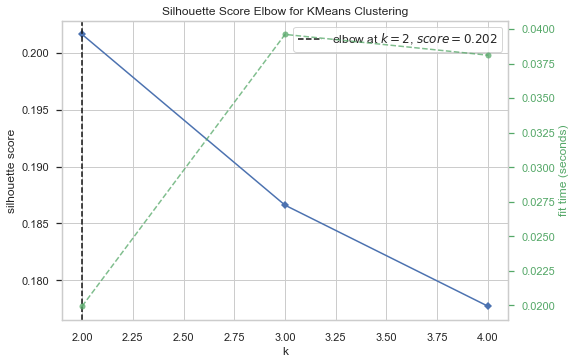

In [26]:
get_elbow(base_dec,int(min.value),int(max.value),int(met_nclu.value))

### Selecciona el modelo

In [31]:
met_clu=widgets.Dropdown(
    options=[('KMeans'), ('Spectral'), ('Agglomerative'),('DBSCAN'), ('Optics')],
    value=mejor_modelo[2],
    description='Metodo:',
    disabled=False,
)
param = widgets.RadioButtons(
    options=['Otro',mejor_modelo[1]],
     value=mejor_modelo[1],
    description='Parámetros:',
    disabled=False
)
otroparam = widgets.Text(
    value=str(mejor_modelo[1]),
    placeholder='ingrese parametros',
    description='Cuál:',
    disabled=False
)
opc_param=widgets.HBox([param,otroparam])
display(widgets.VBox([met_clu,opc_param]))

In [41]:
if(param.value=='Otro'):
    parametros=otroparam.value
else:
    parametros=param.value
if(type(parametros)!=dict): parametros=ast.literal_eval(parametros)
dat['cluster'] = cluster(base_dec,met_clu.value,parametros)
metricas_no_supervisado(base_dec,dat['cluster'])

silhouette	calinski_harabasz	davies_bouldin
------------------------------------------------------------
0.202		14.006			1.699


## Transformaciones

Se probarán Algunas transformaciones sobre los datos, de manera que se pueda visualizar los resultados graficamente

([<matplotlib.axis.XTick at 0x1f9278a4af0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

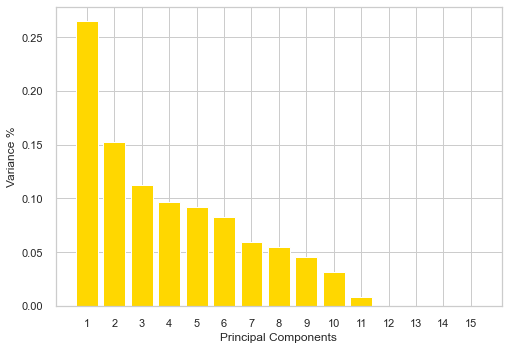

In [51]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10,n_components=len(base_dec.columns))
X_kpca = pd.DataFrame(kpca.fit_transform(base_dec))
X_back = pd.DataFrame(kpca.inverse_transform(X_kpca))
pca = PCA(n_components=len(base_dec.columns))
X_pca = pd.DataFrame(pca.fit_transform(base_dec))

# Plot results
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)


In [57]:
mejor_modelo_pca=select_model(X_pca.iloc[:,:2],int(min.value),int(max.value),int(met_nclu.value))
mejor_modelo_Kpca=select_model(X_kpca.iloc[:,:2],int(min.value),int(max.value),int(met_nclu.value))
mejor_modelo_back=select_model(X_back.iloc[:,:2],int(min.value),int(max.value),int(met_nclu.value))
print("Mejor Modelo PCA:",mejor_modelo_pca[2])
print("Parámetros PCA:",mejor_modelo_pca[1])
print("Score PCA:",mejor_modelo_pca[0])
print("Mejor Modelo KernelPCA:",mejor_modelo_Kpca[2])
print("Parámetros KernelPCA:",mejor_modelo_Kpca[1])
print("Score KernelPCA:",mejor_modelo_Kpca[0])
print("Mejor Modelo Inversa KernelPCA:",mejor_modelo_back[2])
print("Parámetros Inversa KernelPCA:",mejor_modelo_back[1])
print("Score Inversa KernelPCA:",mejor_modelo_back[0])

Parametro:  {'n_clusters': 2} Score:  0.4811089500951371
Parametro:  {'n_clusters': 3} Score:  0.6086178731870762
Parametro:  {'n_clusters': 4} Score:  0.6010968121302221
Parametro:  {'n_clusters': 5} Score:  0.662349519920051
Parametro:  {'affinity': 'rbf', 'n_clusters': 2} Score:  0.4811089500951371
Parametro:  {'affinity': 'rbf', 'n_clusters': 3} Score:  0.6086178731870762
Parametro:  {'affinity': 'rbf', 'n_clusters': 4} Score:  0.6010968121302221
Parametro:  {'affinity': 'rbf', 'n_clusters': 5} Score:  0.59407944622088
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 2} Score:  0.4767730166193829
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 3} Score:  0.6026365386459505
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 4} Score:  0.5382280048962563
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 5} Score:  0.6397827266279738
Parametro:  {'linkage': 'ward', 'n_clusters': 2} Score:  0.40727822304601446
Parametro:  {'linkage': 'ward', 'n

Parametro:  {'affinity': 'rbf', 'n_clusters': 5} Score:  0.7136943742766897
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 2} Score:  -0.15215533166380196
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 3} Score:  0.051799167878853955
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 4} Score:  0.09120317280875637
Parametro:  {'affinity': 'nearest_neighbors', 'n_clusters': 5} Score:  0.3560389271453679
Parametro:  {'eps': 0.9, 'min_samples': 2} Score:  0.8695837584375813
Parametro:  {'eps': 0.9, 'min_samples': 5} Score:  0.8695837584375813
Parametro:  {'eps': 0.9, 'min_samples': 7} Score:  0.8695837584375813
Parametro:  {'eps': 0.9, 'min_samples': 10} Score:  0.8695837584375813
Parametro:  {'linkage': 'ward', 'n_clusters': 2} Score:  0.8695837584375813
Parametro:  {'linkage': 'ward', 'n_clusters': 3} Score:  0.9336160384518574
Parametro:  {'linkage': 'ward', 'n_clusters': 4} Score:  0.8916495439426353
Parametro:  {'linkage': 'ward', 'n_clusters': 5} S

In [59]:
dat['cluster_pca'] = cluster(X_pca.iloc[:,:2],mejor_modelo_pca[2],mejor_modelo_pca[1])
dat['cluster_kpca'] = cluster(X_kpca.iloc[:,:2],mejor_modelo_Kpca[2],mejor_modelo_Kpca[1])
dat['cluster_backpca'] = cluster(X_back.iloc[:,:2],mejor_modelo_back[2],mejor_modelo_back[1])

print("PCA:")
metricas_no_supervisado(X_pca.iloc[:,:2],dat['cluster_pca'])
print("Kernel PCA:")
metricas_no_supervisado(X_kpca.iloc[:,:2],dat['cluster_kpca'])
print("inversa Kernel PCA:")
metricas_no_supervisado(X_back.iloc[:,:2],dat['cluster_backpca'])

PCA:
silhouette	calinski_harabasz	davies_bouldin
------------------------------------------------------------
0.662		120.735			0.514
Kernel PCA:
silhouette	calinski_harabasz	davies_bouldin
------------------------------------------------------------
0.651		147.266			0.447
inversa Kernel PCA:
silhouette	calinski_harabasz	davies_bouldin
------------------------------------------------------------
0.934		976.398			0.106


<Figure size 576x396 with 0 Axes>

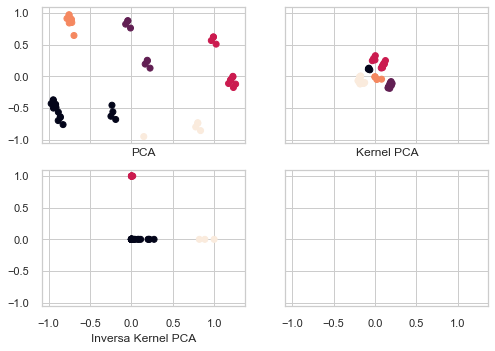

In [64]:
f = plt.figure()    
f, axes = plt.subplots(nrows = 2, ncols = 2, sharex=True, sharey = True)

axes[0][0].scatter(X_pca[0], X_pca[1], c=dat['cluster_pca'])
axes[0][0].set_xlabel('PCA', labelpad = 5)
axes[0][1].scatter(X_kpca[0], X_kpca[1], c=dat['cluster_kpca'])
axes[0][1].set_xlabel('Kernel PCA', labelpad = 5)
axes[1][0].scatter(X_back[0], X_back[1], c=dat['cluster_backpca'])
axes[1][0].set_xlabel('Inversa Kernel PCA', labelpad = 5)
plt.show()

## Resultados *

En la carpeta ./Resultados encontrarás las gráficas

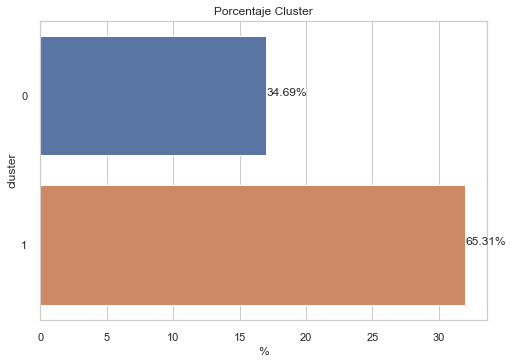

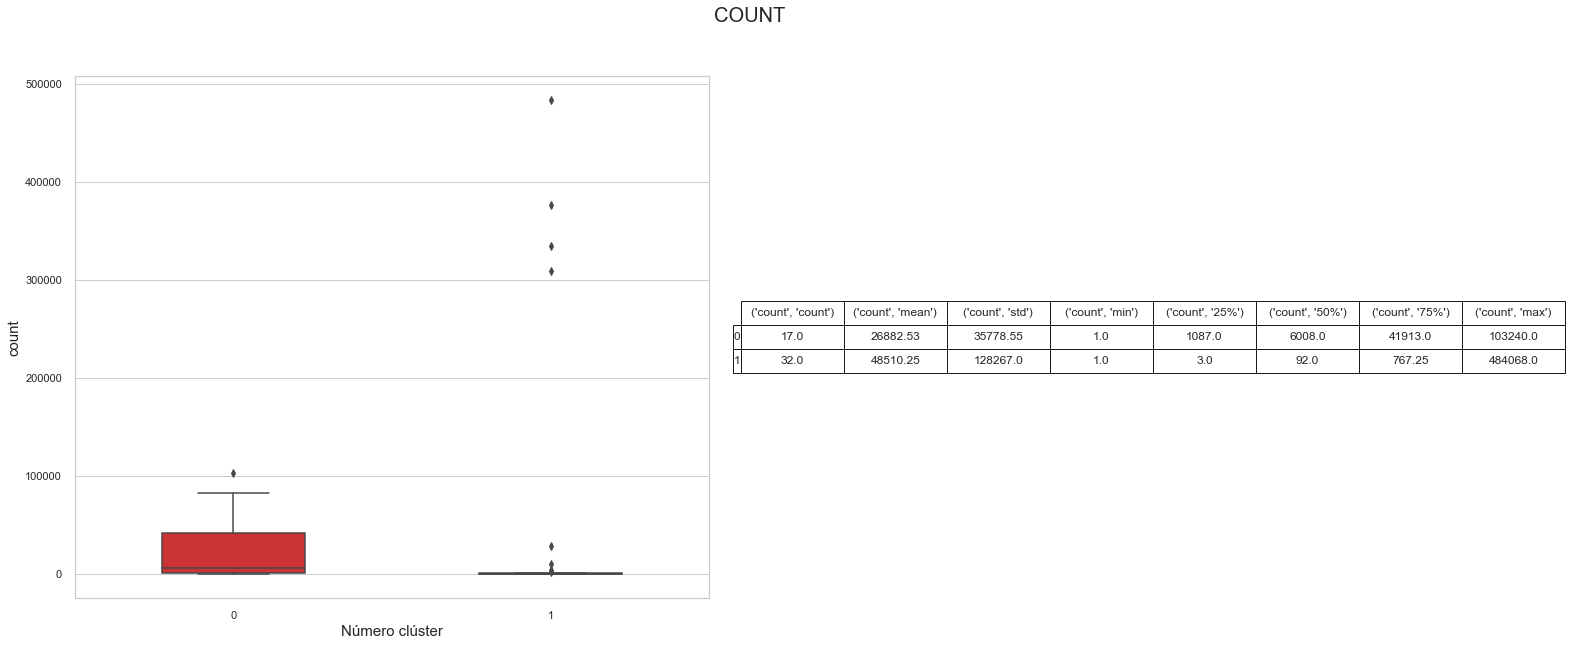

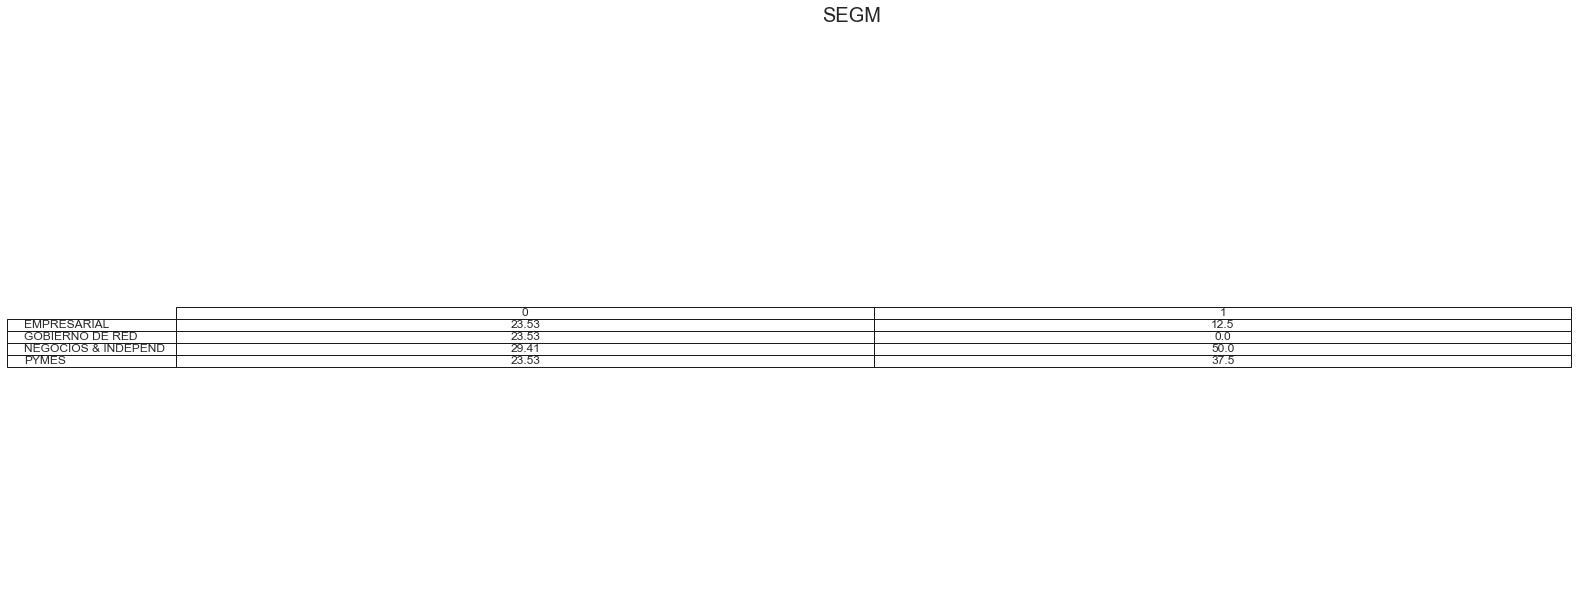

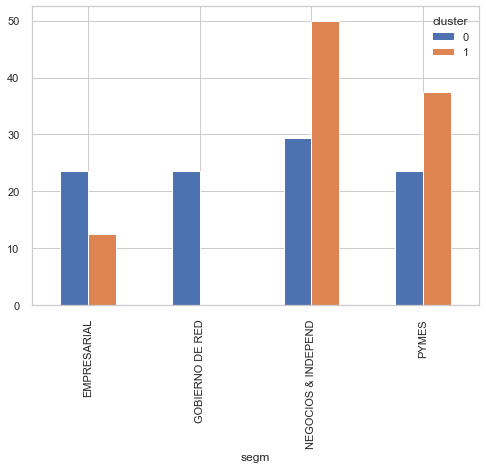

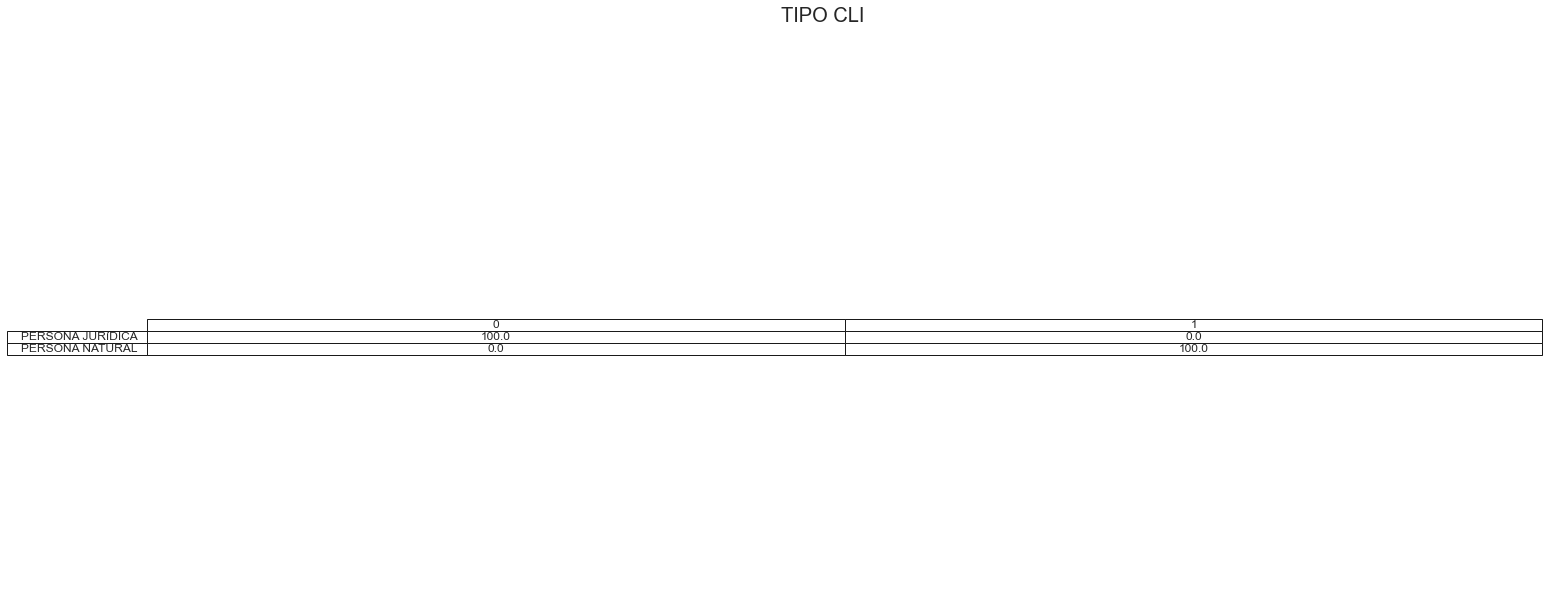

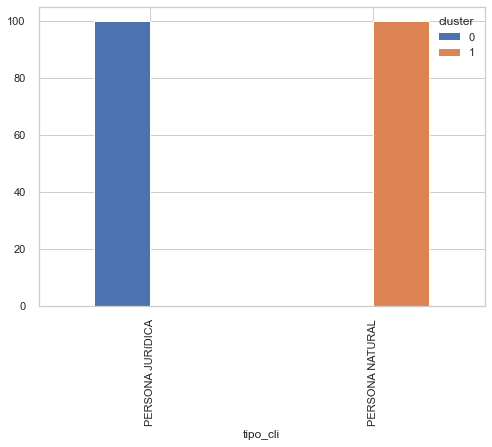

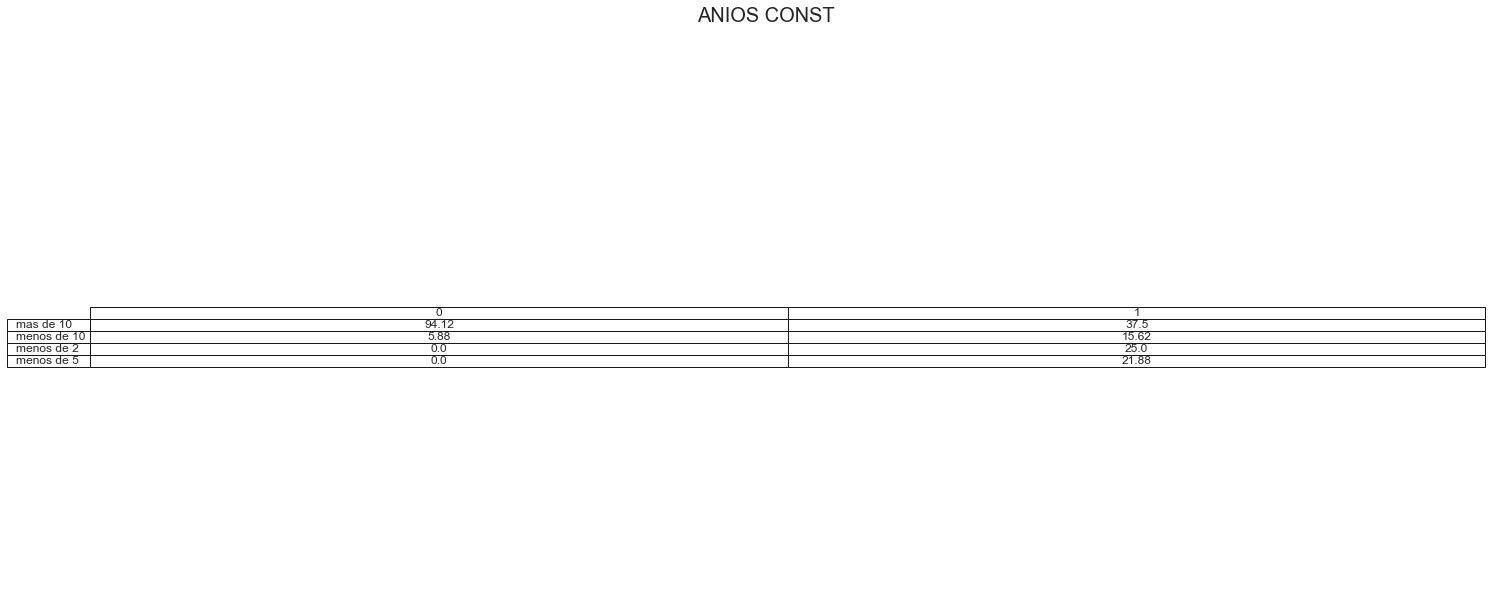

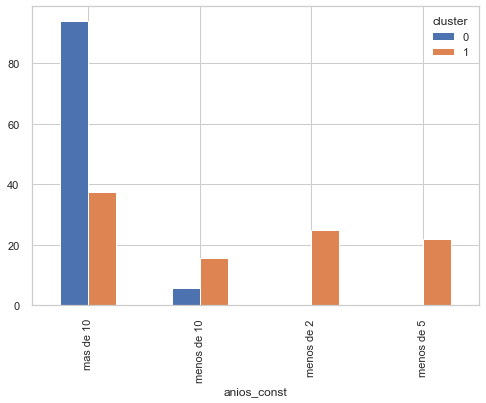

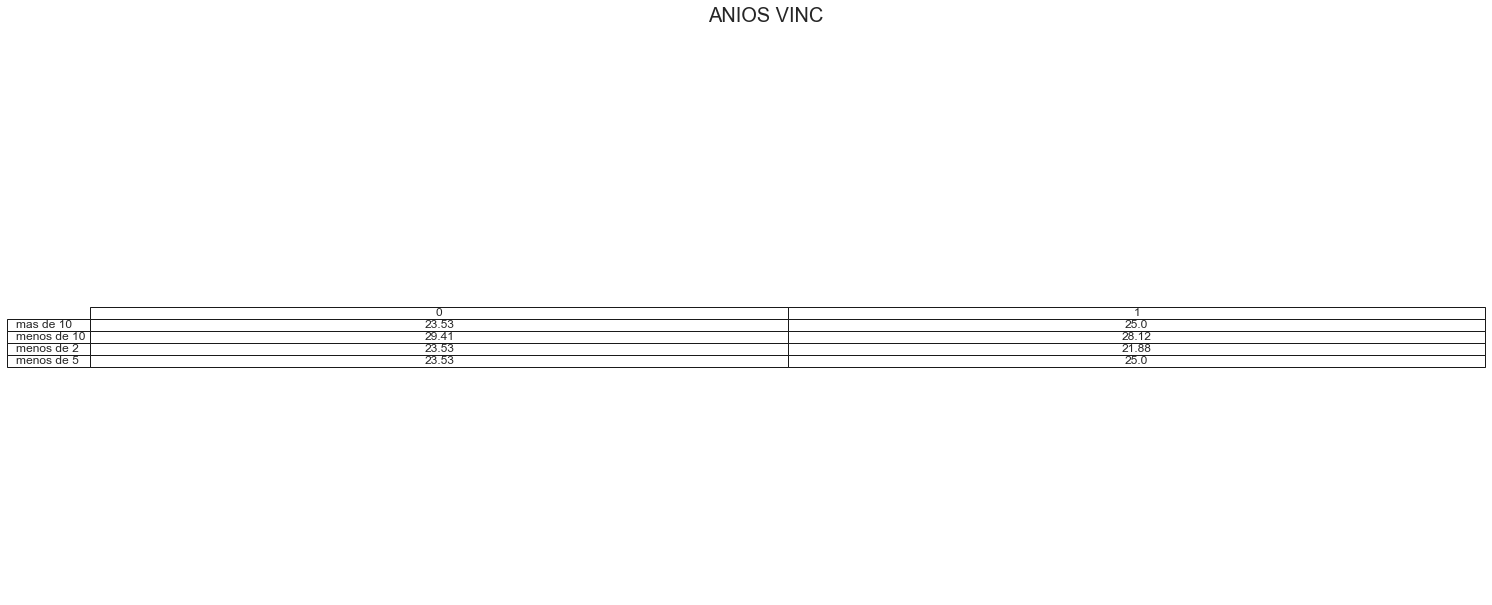

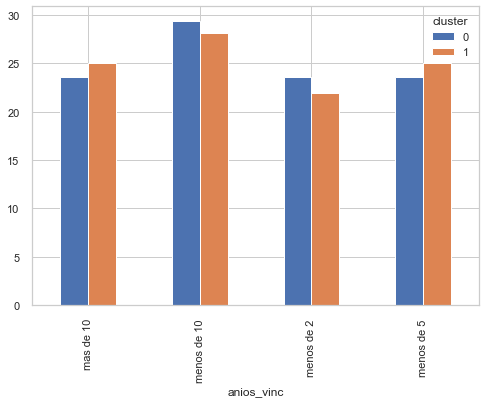

In [207]:
interpretacion(dat,num,cat)

In [248]:
base_dec['cluster'] = dat['cluster']
principales_vars(base_dec)

,x,y,medias_clus
0,Cluster 1,tipo_cli_PERSONA JURíDICA,1.000000
1,Cluster 1,anios_const_mas de 10,0.941176
2,Cluster 1,segm_NEGOCIOS & INDEPEND,0.294118
3,Cluster 1,anios_vinc_menos de 10,0.294118
4,Cluster 1,segm_EMPRESARIAL,0.235294
0,Cluster 1,count,0.071306
1,Cluster 1,anios_const_menos de 10,0.058824
2,Cluster 1,tipo_cli_PERSONA NATURAL,0.000000
3,Cluster 1,anios_const_menos de 2,0.000000
4,Cluster 1,anios_const_menos de 5,0.000000


## Exportar

In [222]:
ruta_salida=widgets.Text(
        value=ruta,
        placeholder='¿Dónde quiere guardar resultados?',
        description='Ruta Guardar:',
        disabled=False
        )
nombre_archivo=widgets.Text(
        value="resultados",
        placeholder='¿Nombre archivo guardar resultados?',
        description='Nombre:',
        disabled=False
        )
formato_salida=widgets.Dropdown(
    options=[('xlsx',1), ('csv',0)],
    value=1,
    description='Formato:',
    disabled=False,
)
opc_exp = widgets.HBox([ruta_salida,nombre_archivo,formato_salida]) 
display(opc_exp)

In [246]:
# formato:
# 1: xlsx
# 2. csv
exportar(dat,ruta_salida.value,nombre_archivo.value,formato_salida.value)
dat

,segm,tipo_cli,anios_const,anios_vinc,count,cluster
0,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 5,92,1
1,NEGOCIOS & INDEPEND,PERSONA JURíDICA,mas de 10,menos de 10,103240,0
2,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,menos de 10,118,1
3,PYMES,PERSONA NATURAL,menos de 2,menos de 5,2,1
4,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 10,menos de 5,112,1
5,GOBIERNO DE RED,PERSONA JURíDICA,mas de 10,menos de 10,739,0
6,PYMES,PERSONA NATURAL,menos de 2,menos de 10,3,1
7,NEGOCIOS & INDEPEND,PERSONA NATURAL,menos de 2,mas de 10,92,1
8,NEGOCIOS & INDEPEND,PERSONA NATURAL,mas de 10,mas de 10,484068,1
9,EMPRESARIAL,PERSONA NATURAL,mas de 10,mas de 10,284,1
